In [1]:
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import math
import statistics as stat
import random

from utils import cross_bin_matching, neighbour_matching, PairSwapICI_test, marg_indep_test
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib import ticker, patches

lblue  = (40/255,103/255,178/255)
sgreen = (46/255,139/255,87/255)

## Part 1: Type I error analysis

In [2]:
def effect_on_validity(nrep, gamma_seq, n):
    """
    Simulates the effect of varying monotonicity strength on the conservatism of the PairSwap-ICI test.

    This function generates data under two settings, creates matchings using 
    neighbour matching and cross-bin matching, and computes p-values for each 
    combination of gamma (monotonicity strength), setting, and matching method.

    Parameters:
    nrep (int): number of repetitions.
    gamma_seq (array-like): monotonicity-strength values.
    n (int): sample size.

    Returns:
        dict: A nested dictionary storing computed p-values for different settings, 
              gamma values, and matching methods.
    """
    # Initialize p-value storage: with structure [setting][matching][gamma]
    pvalues = defaultdict(lambda: defaultdict(lambda: np.zeros(nrep)))
    
    # Simulation loop
    for l in tqdm(range(nrep), desc="Computing p values"):
        # Generate independent standard normal variables Z and Y
        Z = np.random.normal(0, 1, n)
        Y = np.random.normal(0, 1, n)
        K = int(np.floor(n ** (2 / 3)))  # Number of bins for cross-bin matching

        # Compute matching based on (Y,Z)
        matchings = {
            'nbhd': neighbour_matching(Y, Z),
            'cb': cross_bin_matching(Y, Z, K),
        }

        # Iterate over gamma values
        for gamma in gamma_seq:
            # Iterate over settings: linear and non-linear dependence
            for setting in range(2):
                if setting == 0:
                    mu = gamma * Z  # Linear dependence
                elif setting == 1:
                    mu = norm.cdf(gamma * Z)  # Non-linear dependence

                # Generate data for X
                X = mu + np.random.normal(0, 1, n)

                # Compute p-values for each matching method
                for matching, M in matchings.items():
                    pvalues[(setting, matching)][gamma][l] = PairSwapICI_test(X, Y, M)

    return pvalues

# === simulation results ===
nrep = 10000; n = 1000
gamma_seq = 10 ** np.linspace(-1, 1, 7)  # Sequence of gamma values in [.1, 1, 10]

results = effect_on_validity(nrep, gamma_seq, n)

Computing p values: 100%|█████████████████| 10000/10000 [08:21<00:00, 19.93it/s]


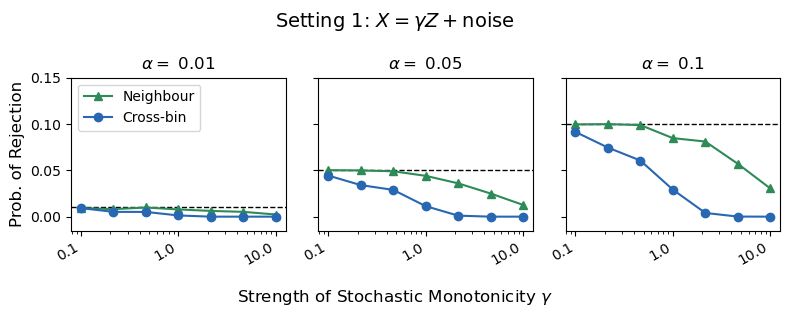

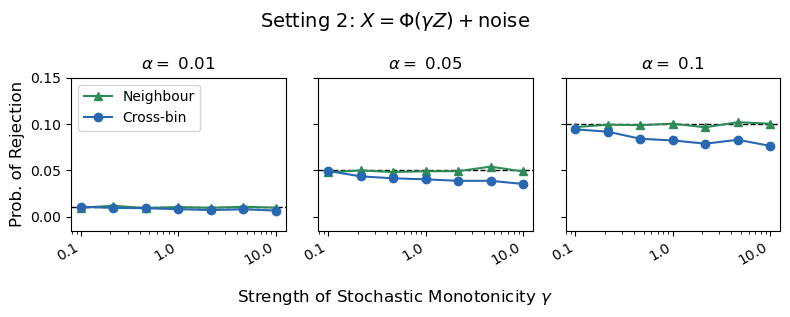

In [7]:
# Parameters
alphas = [0.01, 0.05, 0.1]  # Significance levels
col_titles = [r'$\alpha=$ {}'.format(a) for a in alphas]  # Column titles
titles = [
    r'$X = \gamma Z + \text{noise}$',
    r'$X = \Phi(\gamma Z) + \text{noise}$'
]  # Titles for the two settings
methods = [
    ('nbhd', "Neighbour", sgreen, '^'),
    ('cb', "Cross-bin", lblue, 'o'),
]


def plot_validity_curves(results, gamma_seq, nrep, settings_titles, alphas, methods):
    """
    Plots validity curves against monotonicity strength for different settings and significance levels.

    Args:
        results (dict): Nested dictionary with p-values for different settings, matchings, and gammas.
        gamma_seq (list): Sequence of gamma values tested.
        nrep (int): Number of repetitions in the simulation.
        settings_titles (list): Titles for the settings being tested.
        alphas (list): List of significance levels.
        methods (list): List of tuples containing method key, matching label, color, and marker.

    Outputs:
        Saves and displays plots for each setting.
    """
    for setting, title in enumerate(settings_titles):
        fig, axes = plt.subplots(nrows=1, ncols=len(alphas), figsize=(8, 3.3), sharex=True, sharey=True)
        axes[0].set_ylim([-0.015, 0.15])

        for col, alpha in enumerate(alphas):
            axes[col].set_title(col_titles[col], fontsize=12)
            axes[col].axhline(y=alpha, color='black', linestyle='--', linewidth=1)
            
            for key, matching, color, marker in methods:
                rejection_probs = [
                    np.mean(results[(setting, key)][gamma] < alpha) for gamma in gamma_seq # compute type-I error
                ]
                axes[col].plot(
                    gamma_seq, rejection_probs, marker=marker, linestyle='solid', color=color, label=matching
                )

        for ax in axes:
            ax.set_xscale('log')
            ax.set_xticks([0.1, 1, 10])  # Only three labels
            ax.set_xticklabels([0.1, 1, 10], rotation=30, horizontalalignment='right')
            ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

        axes[0].legend(loc='upper left', fontsize=10)

        axes[0].set_ylabel('Prob. of Rejection', fontsize=12)
        fig.supxlabel('Strength of Stochastic Monotonicity $\\gamma$', y=0.03, fontsize=12)
        fig.suptitle(f'Setting {setting + 1}: {title}', y=0.93, fontsize=14)

        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout
        fig.savefig(f'figures/validity_curve_log_nrep={nrep}_setting={setting + 1}.pdf', bbox_inches='tight')
        plt.show()

# === visualize our results ===
plot_validity_curves(results, gamma_seq, nrep, titles, alphas, methods)


## Part 2: power analysis

In [4]:
def sim_YZ(n, setting):
    """ Simulates paired samples (Y, Z) with specified correlation structure. """
    
    if setting == 1:
        rho = 0
    elif setting == 2:
        rho = 0.5
    elif setting == 3:
        rho = -0.5
    else:
        raise ValueError("Invalid setting. Choose from {1, 2, 3}.")

    # Generate multivariate normal samples
    cov = (1 - rho) * np.eye(2) + rho * np.ones((2, 2))
    Y, Z = np.random.multivariate_normal([0, 0], cov, size=n).T

    return Y, Z

In [5]:
# --- simulation framework for the power calculation ---

nrep = 10000  # Number of repetitions for simulations
alpha = 0.1   # Significance level
nseq = np.array([100, 500, 1000, 2000, 3000, 5000])  # Sequence of sample sizes

def power_analysis_sim(setting):
    """
    Performs a power analysis simulation to evaluate the performance of different matching methods.

    Args:
        setting (int): Specifies the correlation structure for the Y and Z variables.
                       - 1: Independent variables.
                       - 2: Positively correlated variables.
                       - 3: Negatively correlated variables.

    Returns:
        power (dict): A nested dictionary where:
                - Keys are tuples (gamma, matching).
                - Values are dictionaries where keys are sample sizes `n` and 
                                                values are the estimated power (proportion of rejections).

    """
    # Initialize storage for p-values and power
    pvalues = defaultdict(lambda: defaultdict(lambda: np.zeros(nrep)))
    power = defaultdict(lambda: defaultdict(float))

    for n in nseq:
        for l in tqdm(range(nrep), desc=f"Processing sample size {n}, Setting {setting}"):
            # Generate data
            Y, Z = sim_YZ(n, setting)

            # Define matching methods
            matchings = {
                'nbhd': neighbour_matching(Y, Z),  # Neighbor matching
                'cb': cross_bin_matching(Y, Z, np.floor(n ** (2 / 3)))  # Cross-bin matching with roughly n^{2/3} bins
            }

            beta = 1 / (n ** (1 / 3))  # Slope for linear dependence of Y on X, after controlling for Z

            # compute p-values for different gamma values
            for gamma in [0.5, 2]:
                X = gamma * Z + beta * Y + np.random.normal(0, 1, n)
                for label, M in matchings.items():
                    pvalues[(gamma, label)][n][l] = PairSwapICI_test(X, Y, M)

        # Compute power for each combination of (gamma, label)
        for key in pvalues:
            power[key][n] = np.mean(pvalues[key][n] < alpha)

    return pvalues, power

# === power calculation for the three different settings ===
power_results = []
for setting in [1, 2, 3]:
    _, power = power_analysis_sim(setting)
    power_results.append(power)


Processing sample size 100, Setting 1: 100%|█| 10000/10000 [00:07<00:00, 1314.89
Processing sample size 500, Setting 1: 100%|█| 10000/10000 [00:41<00:00, 241.45i
Processing sample size 1000, Setting 1: 100%|█| 10000/10000 [01:26<00:00, 115.77
Processing sample size 2000, Setting 1: 100%|█| 10000/10000 [02:52<00:00, 58.05i
Processing sample size 3000, Setting 1: 100%|█| 10000/10000 [04:24<00:00, 37.78i
Processing sample size 5000, Setting 1: 100%|█| 10000/10000 [07:25<00:00, 22.46i
Processing sample size 100, Setting 2: 100%|█| 10000/10000 [00:07<00:00, 1365.25
Processing sample size 500, Setting 2: 100%|█| 10000/10000 [00:40<00:00, 244.24i
Processing sample size 1000, Setting 2: 100%|█| 10000/10000 [01:25<00:00, 117.59
Processing sample size 2000, Setting 2: 100%|█| 10000/10000 [02:50<00:00, 58.54i
Processing sample size 3000, Setting 2: 100%|█| 10000/10000 [04:22<00:00, 38.10i
Processing sample size 5000, Setting 2: 100%|█| 10000/10000 [07:22<00:00, 22.62i
Processing sample size 100, 

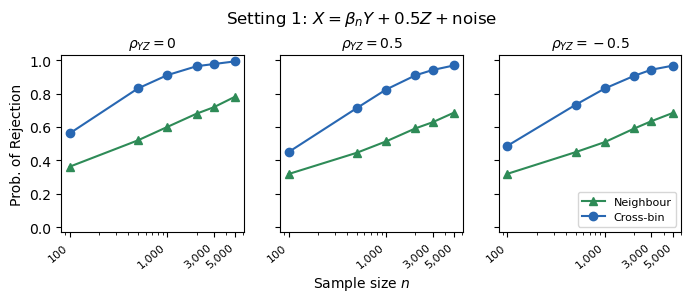

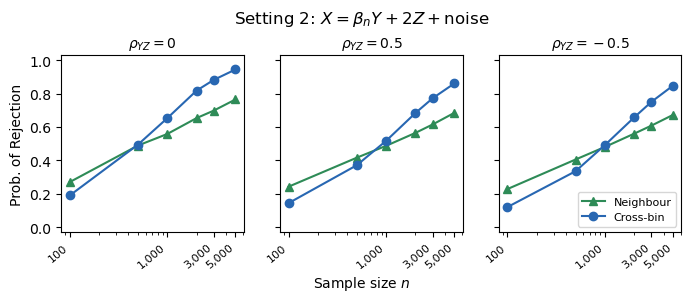

In [6]:
def plot_power_results(power_results, nseq, titles, methods, nrep):
    """
    Plots power analysis results for different settings, sample sizes, and methods.

    Args:
        power_results (list): List of dictionaries storing power values for different settings.
        nseq (array): Array of sample sizes used in simulations.
        titles (list): Titles for the settings, formatted as LaTeX strings.
        methods (list): List of tuples containing method keys, matching labels, colors, and markers.
        nrep (int): Number of repetitions in the simulation.

    Outputs:
        Saves and displays plots for each gamma setting.
    """
    gamma_values = [0.5, 2]  # Gamma values for different settings
    col_titles = [r'$\rho_{YZ} = 0$', r'$\rho_{YZ} = 0.5$', r'$\rho_{YZ} = -0.5$']

    for ind, gamma in enumerate(gamma_values):
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 2.3), sharex=True, sharey=True)

        for col in range(3):
            axes[col].set_title(col_titles[col], fontsize=10)

            for key, label, color, marker in methods:
                power_data = power_results[col][(gamma, key)]
                axes[col].semilogx(
                    nseq,
                    list(power_data.values()),
                    marker=marker,
                    linestyle='solid',
                    color=color,
                    label=label,
                )

        axes[0].set_ylabel('Prob. of Rejection', fontsize=10)
        axes[0].set_ylim([-0.03, 1.03])

        # Select fewer x-ticks to reduce overlap
        selected_xticks = sorted(set([nseq[0], nseq[-1]] + list(nseq[::2])))
        for ax in axes:
            ax.set_xticks(selected_xticks)
            ax.set_xticklabels(
                [f'{int(x):,}' for x in selected_xticks],
                rotation=40,
                ha='right',
                fontsize=8,
            )

        axes[2].legend(loc='lower right', fontsize=8)

        fig.supxlabel('Sample size $n$', y=-0.15, fontsize=10)
        fig.suptitle(f'Setting {ind + 1}: {titles[ind]}', y=1.08, fontsize=12)

        fig.savefig(f'figures/power-nrep={nrep}-gamma={gamma:.1f}.pdf', bbox_inches='tight')
        plt.show()


# === visualize our results ===
methods = [
    ('nbhd', "Neighbour", sgreen, '^'),
    ('cb', "Cross-bin", lblue, 'o'),
]
titles = [r'$X = \beta_n Y + 0.5 Z + \text{noise}$', r'$X = \beta_n Y + 2 Z + \text{noise}$']
plot_power_results(power_results, nseq, titles, methods, nrep)
